In [1]:
import pandas as pd
df = pd.read_csv("pistachios.csv", index_col=0)
df.head()

/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,filename,filename_camelcase,pistachio_type,major_axis,minor_axis,area,perimeter,ellipse_area,ellipse_perimeter,major_axes,...,k,r,co,sf1,sf2,sf3,sf4,percent_area,distance_from_ellipse,average_hue
0,kirmizi (23).jpg,kirmizi_23.jpg,0,453.495544,220.994598,78732.0,1216.631593,78712.655547,1120.665639,453.495544,...,2.052066,0.787594,0.698079,0.005761,0.002808,0.487314,0.487314,0.240742,0.747299,104.021402
1,kirmizi 21.jpg,kirmizi_21.jpg,0,464.291748,248.325897,89545.0,1268.371705,90553.003463,1169.652914,464.291748,...,1.869687,0.831761,0.731334,0.005127,0.002742,0.534849,0.534849,0.271703,0.862266,108.530097
2,kirmizi 35.jpg,kirmizi_35.jpg,0,481.507446,219.244537,82487.0,1223.376759,82912.816940,1175.303335,481.507446,...,2.196212,0.754278,0.674781,0.005807,0.002644,0.455329,0.455329,0.246336,0.933590,103.808665
3,kirmizi 475.jpg,kirmizi_475.jpg,0,455.230591,236.374313,83621.5,1189.217379,84512.626684,1139.466757,455.230591,...,1.925889,0.817953,0.720584,0.005387,0.002797,0.519241,0.519241,0.252661,1.123648,106.372142
4,kirmizi 313.jpg,kirmizi_313.jpg,0,416.695648,225.598877,73160.5,1095.702659,73832.194933,1052.621353,416.695648,...,1.847064,0.837358,0.735799,0.005644,0.003056,0.541400,0.541400,0.224061,1.001319,105.179346


In [2]:
tmp = pd.read_csv("second_last_layer.csv", index_col=0)
tmp.head()

,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.009042,0.396989,0.0,0.027226,0.000138,0.0
1,0.000000,0.000000,0.000000,0.386188,0.0,0.021057,0.000124,0.0
2,0.000000,0.000000,0.000000,0.383872,0.0,0.023287,0.000180,0.0
3,0.000000,0.000000,0.000000,0.389859,0.0,0.015770,0.000124,0.0
4,0.031194,0.034356,0.021480,0.320941,0.0,0.039477,0.000101,0.0


In [3]:
df = pd.concat([df, tmp], axis=1)
df.head()
df.to_csv("pistachios_with_cnn.csv")

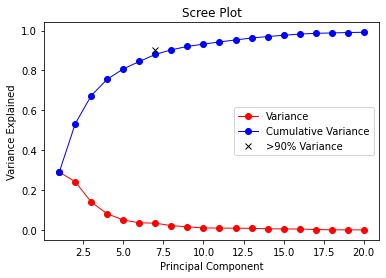

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_X = scaler.fit_transform(df[df.columns[3:]])

#define PCA model to use
pca = PCA(n_components=20)

#fit PCA model to data
pca_fit = pca.fit_transform(scaled_X)
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum > 0.9)[0][0]

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot(cutoff, cum_sum[cutoff], "kx", label=">90% Variance")
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

In [5]:
import statsmodels.api as sm
X = pca_fit[:, :cutoff + 1]
y = df["pistachio_type"]
logit_model=sm.Logit(y,X)
result=logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.004635
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
==============================================================
Model:              Logit            Pseudo R-squared: 0.993  
Dependent Variable: pistachio_type   AIC:              35.9115
Date:               2022-07-24 18:14 BIC:              81.2898
No. Observations:   2148             Log-Likelihood:   -9.9557
Df Model:           7                LL-Null:          -1465.6
Df Residuals:       2140             LLR p-value:      0.0000 
Converged:          1.0000           Scale:            1.0000 
No. Iterations:     14.0000                                   
----------------------------------------------------------------
        Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
----------------------------------------------------------------
x1      0.6054     0.2270    2.6665   0.0077    0.1604    1.0504
x2     -2.2938     0.6528   -3.5139   0.0004   -3.5732   -1.0144
x3      2.8972     0.8244    3.5145   0.0004    1.2815    4.5129
x4      2.6156     0.7631    3.4275   0.0006    1.1199    4.1113
x5      0.5332     0.2954    1.8050   0.0711   -0.0458    1.1122
x6      1.0480     0.4302    2.4361   0.0148    0.2048    1.8912
x7      5.6431     1.5054    3.7486   0.0002    2.6926    8.5935
x8      0.7762     0.5191    1.4954   0.1348   -0.2411    1.7936
==============================================================

"""

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 1.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       374
           1       1.00      0.99      1.00       271

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645



/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
logreg.score(X, y)

0.9986033519553073

In [8]:
from sklearn.manifold import TSNE
# dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
tsne_X = tsne.fit_transform(scaled_X) # 2D representation
# y    = range(len(digits.target_names)) # labels for visual
# visualize
# plt.figure(figsize=(10, 10))
tsne_X

array([[-11.492138 ,  -5.8462124],
       [ -2.834706 ,  32.25245  ],
       [ -0.7666459,  24.98514  ],
       ...,
       [ 21.767897 ,  20.163347 ],
       [ 26.433018 ,  56.080322 ],
       [ 29.956652 , -56.034904 ]], dtype=float32)

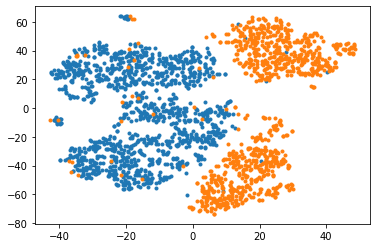

In [9]:
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y == 0]
check_y_0 = tsne_plot_y[y == 0]
check_x_1 = tsne_plot_x[y == 1]
check_y_1 = tsne_plot_y[y == 1]
plt.plot(check_x_0, check_y_0, ".")
plt.plot(check_x_1, check_y_1, ".")

In [10]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9968992248062015

In [11]:
y_pred = clf.predict(X_test)
print('Accuracy of linear svm classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred))

Accuracy of linear svm classifier on test set: 1.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       374
           1       1.00      0.99      1.00       271

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645

